# SVM Practice Session
In this session, we will see how to use Support Vector Machines (SVM) to classify data. In a first time, we will work with generated data, and then we will use SVM to try and predict pulsars stars.

## Imports

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro
import statsmodels.api as sm
from sklearn.svm import SVC
from tqdm import tqdm
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


ModuleNotFoundError: No module named 'pandas'

## Random datasets

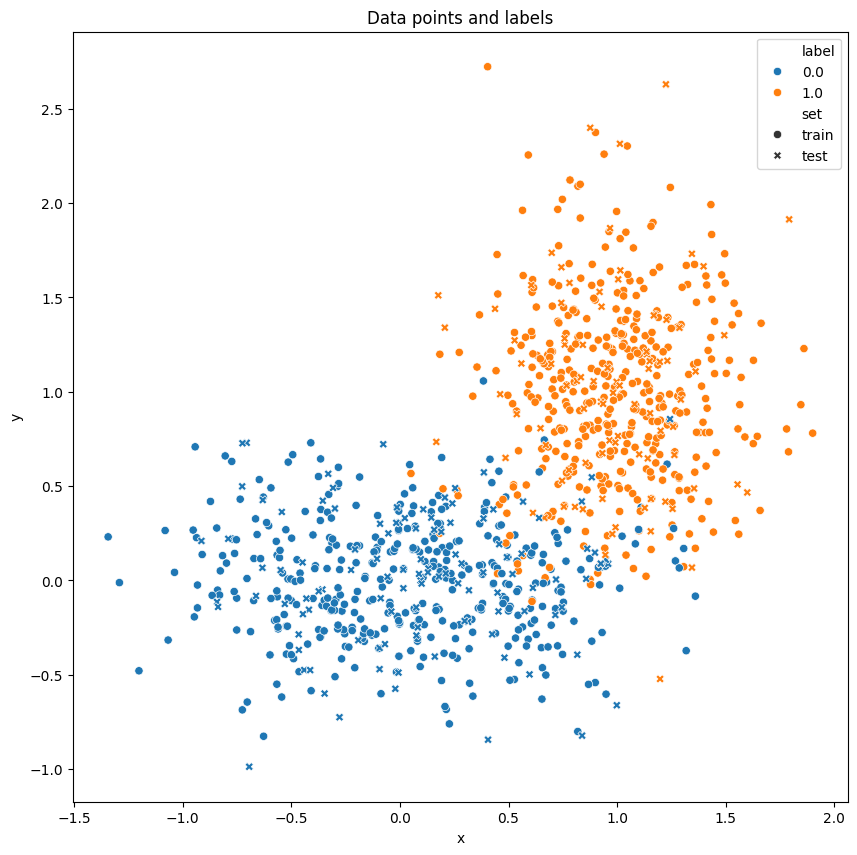

In [ ]:
##--------------------------Section 1.3------------------------------------##

# We generate 1000 points, with 2 features, and 2 classes
# Let's pick a center for each class
center1 = np.array([0, 0])
center2 = np.array([1, 1])

# We generate 500 points around each center, distributed normally
data1 = np.random.normal(loc=center1, # mean
                         scale=(0.5, 0.3), # std deviation
                         size=(500, 2))
data2 = np.random.normal(loc=center2, # mean
                         scale=(0.3, 0.5), # std deviation
                         size=(500, 2))

# We create the labels
labels1 = np.zeros(500)
labels2 = np.ones(500)

# We concatenate the data and the labels
data1 = np.concatenate((data1, labels1.reshape(-1, 1)), axis=1)
data2 = np.concatenate((data2, labels2.reshape(-1, 1)), axis=1)

# We concatenate the two classes
data = np.concatenate((data1, data2), axis=0)

# We shuffle the data
np.random.shuffle(data)

# We split the data into train, and test sets (80% / 20 %)
train, test = train_test_split(data, test_size=0.2)

# (optional)
# We make a dataframe to plot the data, with columns x, y, label, set
train_df = pandas.DataFrame(train, columns=['x', 'y', 'label'])
train_df['set'] = 'train'
test_df = pandas.DataFrame(test, columns=['x', 'y', 'label'])
test_df['set'] = 'test'
data_df = pandas.concat([train_df, test_df], axis=0)
del train_df, test_df

# Visualization of the dataset
plt.figure(figsize=(10, 10))
sns.scatterplot(x='x', y='y', hue='label', style='set', data=data_df)
plt.title('Data points and labels')
plt.show()

## SVM

In [ ]:
# We split the train/test into features and class
X_train = train[:,:2]
y_train = train[:,2:]
X_test = test[:,:2]
y_test = test[:,2:]

# Define the hyperparameters and the model
hyperparameters = {'C': [1, 10, 50, 100], 'kernel': ["linear", "poly", "rbf"], 'gamma': ['scale', 'auto']}
clf = SVC()

# Define the grid search with cross-validation
GS = GridSearchCV(clf, hyperparameters, cv=10)
GS.fit(X_train, y_train.ravel())  # Run the grid search

# Get the best hyperparameters
best_C = GS.best_params_['C']
best_kernel = GS.best_params_['kernel']
best_gamma = GS.best_params_['gamma']
print("Best hyperparameters found:")
print("C:", best_C, "\nkernel:", best_kernel, "\ngamma", best_gamma)

# Create a new SVM model with the best hyperparameters
SVM = SVC(C=best_C, kernel=best_kernel, gamma=best_gamma)
SVM.fit(X_train, y_train.ravel())

# Evaluate the model using cross-validation
y_pred = SVM.predict(X_test)
accuracy = accuracy_score(y_test.ravel(), y_pred)

print("Accuracy on the test set: {:.4f}".format(accuracy))

Best hyperparameters found:
C: 1 
kernel: rbf 
gamma scale
Accuracy on the test set: 0.9600


## Plot of the surface found and support vector

A SVM classifier with the best hyperparameters found was trained. The following graph shows the data points, support vectors and decission boundary

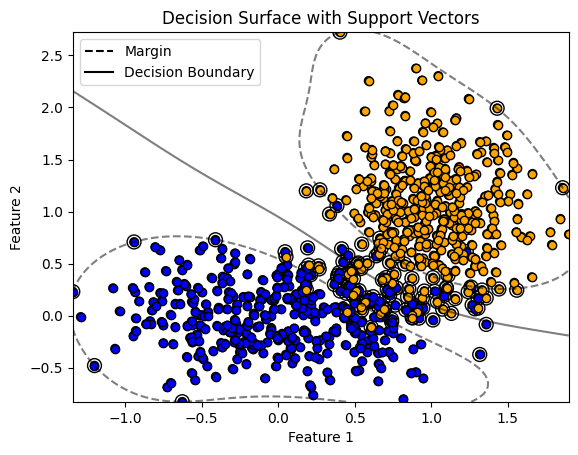

In [ ]:
# We create a grid of points
x_min, x_max = data[:, 0].min() - 0.1, data[:, 0].max() + 0.1
y_min, y_max = data[:, 1].min() - 0.1, data[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Plot decision surface and support vectors
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.ravel(), cmap=plt.cm.Paired, edgecolors='k', label='Training Data')
plt.scatter(SVM.support_vectors_[:, 0], SVM.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='k', label='Support Vectors')

# Modify the color of points for each class
plt.scatter(X_train[y_train.ravel() == 0][:, 0], X_train[y_train.ravel() == 0][:, 1], c='blue', edgecolors='k', label='Class 0')
plt.scatter(X_train[y_train.ravel() == 1][:, 0], X_train[y_train.ravel() == 1][:, 1], c='orange', edgecolors='k', label='Class 1')


# Create grid to evaluate model
xx, yy = np.meshgrid(np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 100),
                     np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 100))
Z = SVM.decision_function(np.c_[xx.ravel(), yy.ravel()])

# Plot decision boundary and margins
Z = Z.reshape(xx.shape)
contour_lines = plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

# Create custom legend elements
legend_elements = [Line2D([0], [0], color='black', linestyle='--', label='Margin'),
                   Line2D([0], [0], color='black', linestyle='-', label='Decision Boundary')]

plt.legend(handles=legend_elements)
plt.title('Decision Surface with Support Vectors')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### The real dataset

In [ ]:
####### -------------------------------------------------------------- PART 1.4 : PULSAR DATA SET ------------------------------------------------------------- #######
pulsar_df = pandas.read_csv('HTRU_2.csv')
column_names = ['Mean of the integrated profile', 'Std of the integrated profile', 'Excess kurtosis of the integrated profile', 'Skewness of the integrated profile', 'Mean of the DM-SNR curve', 'Standard deviation of the DM-SNR curve', 'Excess kurtosis of the DM-SNR curve', 'Skewness of the DM-SNR curve', 'Class']

# Dataframe creation
df = pandas.read_csv("HTRU_2.csv", names=column_names, header=None)
# Features
X = df.iloc[:, :-1]
# Class
y = df.iloc[:, -1]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Concatenating features and target for train set
pulsar_train_df = pandas.concat([X_train, y_train], axis=1)

# Concatenating features and target for test set
pulsar_test_df = pandas.concat([X_test, y_test], axis=1)

# -------------------------------------------------------------------- DATA ANALYSIS OF PULSAR DATA ---------------------------------------------------------------------

# Displaying the shape of the training set
print(pulsar_train_df.shape)
print("\n")

# Displaying the shape of the test set
print(pulsar_test_df.shape)
print("\n")


pulsar_train_df.describe()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(12528, 9)


(5370, 9)




Mean of the integrated profile  \
count                     12528.000000   
mean                        111.041841   
std                          25.672828   
min                           5.812500   
25%                         100.871094   
50%                         115.183594   
75%                         127.109375   
max                         189.734375   

        Standard deviation of the integrated profile  \
count                                   12528.000000   
mean                                       46.521437   
std                                         6.801077   
min                                        24.772042   
25%                                        42.362222   
50%                                        46.931022   
75%                                        50.979103   
max                                        91.808628   

        Excess kurtosis of the integrated profile  \
count                                10793.000000   
mean                                     0.478548   
std                                      1.064708   
min                                     -1.738021   
25%                                      0.024652   
50%                                      0.223678   
75%                                      0.473125   
max                                      8.069522   

        Skewness of the integrated profile   Mean of the DM-SNR curve  \
count                         12528.000000               12528.000000   
mean                              1.778431                  12.674758   
std                               6.208450                  29.613230   
min                              -1.791886                   0.213211   
25%                              -0.188142                   1.910535   
50%                               0.203317                   2.792642   
75%                               0.932374                   5.413253   
max                              68.101622                 222.421405   

        Standard deviation of the DM-SNR curve  \
count                             11350.000000   
mean                                 26.351318   
std                                  19.610842   
min                                   7.370432   
25%                                  14.404353   
50%                                  18.412402   
75%                                  28.337418   
max                                 110.642211   

        Excess kurtosis of the DM-SNR curve   Skewness of the DM-SNR curve  \
count                          12528.000000                   11903.000000   
mean                               8.333489                     105.525779   
std                                4.535783                     107.399585   
min                               -3.139270                      -1.976976   
25%                                5.803063                      35.199899   
50%                                8.451097                      83.126301   
75%                               10.727927                     139.997850   
max                               34.539844                    1191.000837   

       target_class  
count  12528.000000  
mean       0.092034  
std        0.289085  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

In [ ]:
# Checking which features have missing values (Training set)
print(pulsar_train_df.isna().sum())
print("\n\n")

# Checking which features have missing values (Test set)
print(pulsar_test_df.isna().sum())
print("\n\n")

# Computing the ratio of missing values / Total values for training set
missing_value_arr = pulsar_train_df.isna().sum()
feature_names_arr = pulsar_train_df.columns

print("The ratio of missing values for features containing missing in the training set values is : \n")
for i in range(len(missing_value_arr)):
  if(missing_value_arr[i] != 0):
    print(f"{feature_names_arr[i]} { (missing_value_arr[i] / len(pulsar_train_df)) * 100} {'%'}")
  else:
    continue
print("\n")


# Computing the ratio of missing values / Total values for testing set

missing_value_arr = pulsar_test_df.isna().sum()

# We don't redefine the feature names array, since both dataframes contain the same features

print("The ratio of missing values for features containing missing values in the test set is : \n")
for i in range(len(missing_value_arr)):
  if(missing_value_arr[i] != 0):
    print(f"{feature_names_arr[i]} { (missing_value_arr[i] / len(pulsar_test_df)) * 100} {'%'}")
  else:
    continue
print("\n")



 Mean of the integrated profile                     0
 Standard deviation of the integrated profile       0
 Excess kurtosis of the integrated profile       1735
 Skewness of the integrated profile                 0
 Mean of the DM-SNR curve                           0
 Standard deviation of the DM-SNR curve          1178
 Excess kurtosis of the DM-SNR curve                0
 Skewness of the DM-SNR curve                     625
target_class                                        0
dtype: int64



 Mean of the integrated profile                     0
 Standard deviation of the integrated profile       0
 Excess kurtosis of the integrated profile        767
 Skewness of the integrated profile                 0
 Mean of the DM-SNR curve                           0
 Standard deviation of the DM-SNR curve           524
 Excess kurtosis of the DM-SNR curve                0
 Skewness of the DM-SNR curve                     244
target_class                                     5370
dtype: int64

Data is normally distributed in the training set (fail to reject H0)


Data is normally distributed in the test set(fail to reject H0)




/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


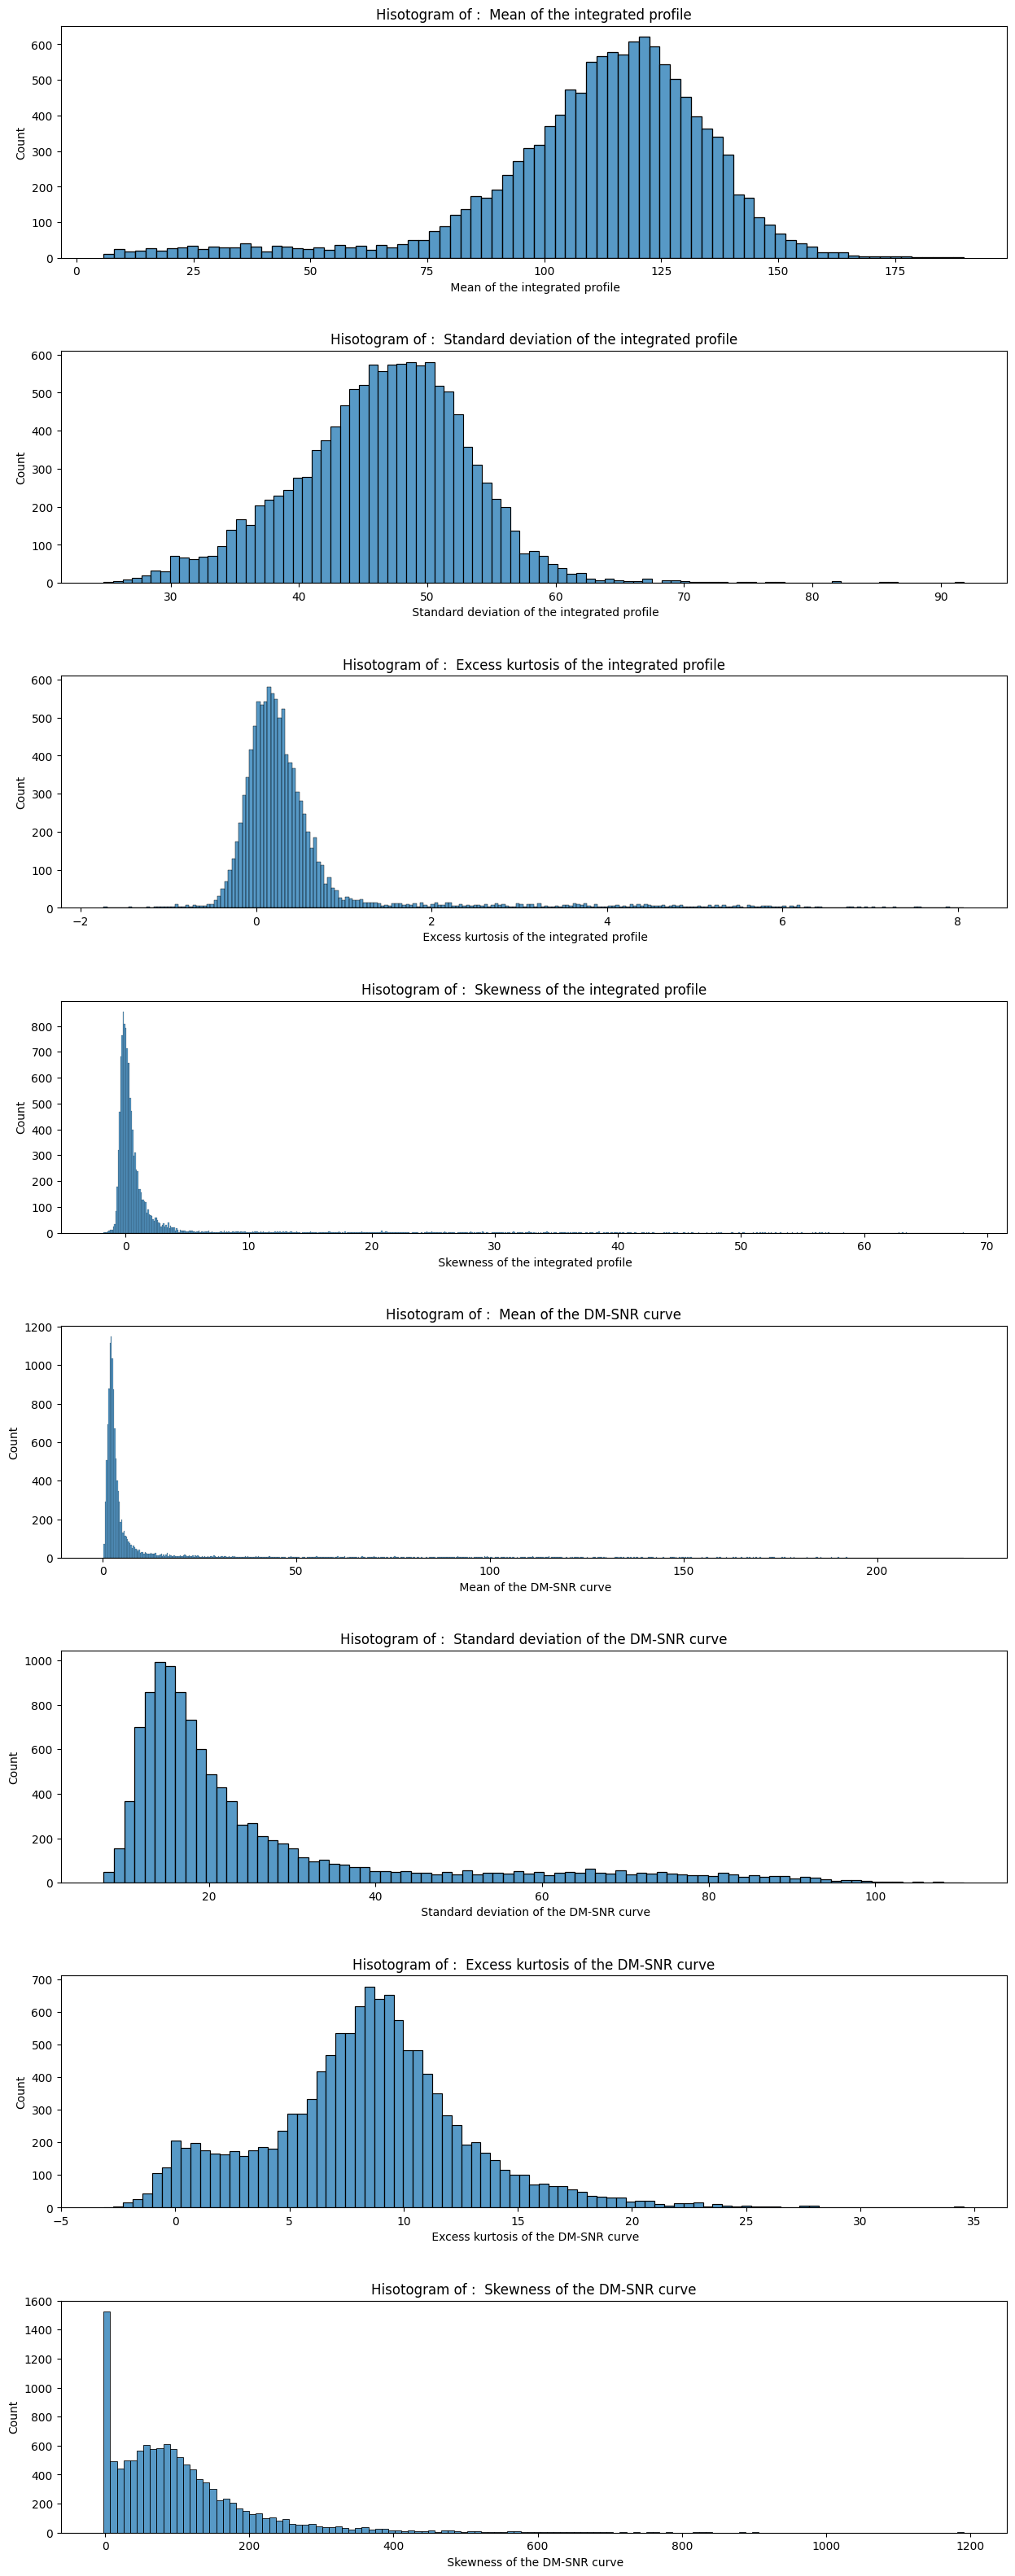

In [ ]:
# ---------------- Checking if the values are normally distributed before imputing ------------------------


# Using Shapiro-Wilk Test to determine whether or not the data is normally distributed
statistic, p_value = shapiro(pulsar_train_df)

# Check if p-value is greater than the significance level (e.g., 0.05)
if p_value > 0.05:
    print("Data is normally distributed in the training set (fail to reject H0)")
else:
    print("Data is not normally distributed in the training set (reject H0)")

print("\n")


# Using Shapiro-Wilk Test to determine whether or not the data is normally distributed for the test set
statistic, p_value = shapiro(pulsar_test_df)

# Check if p-value is greater than the significance level (e.g., 0.05)
if p_value > 0.05:
    print("Data is normally distributed in the test set(fail to reject H0)")
else:
    print("Data is not normally distributed in the test set (reject H0)")

print("\n")

fig, axes = plt.subplots(nrows=8,ncols=1 ,figsize=(15, 40))
fig.subplots_adjust(hspace = .4, wspace=.2)
for i in range(0,len(pulsar_train_df.columns)-1):
  sns.histplot(pulsar_train_df[pulsar_train_df.columns[i]], ax=axes[i]).set_title("Hisotogram of : " + pulsar_train_df.columns[i])



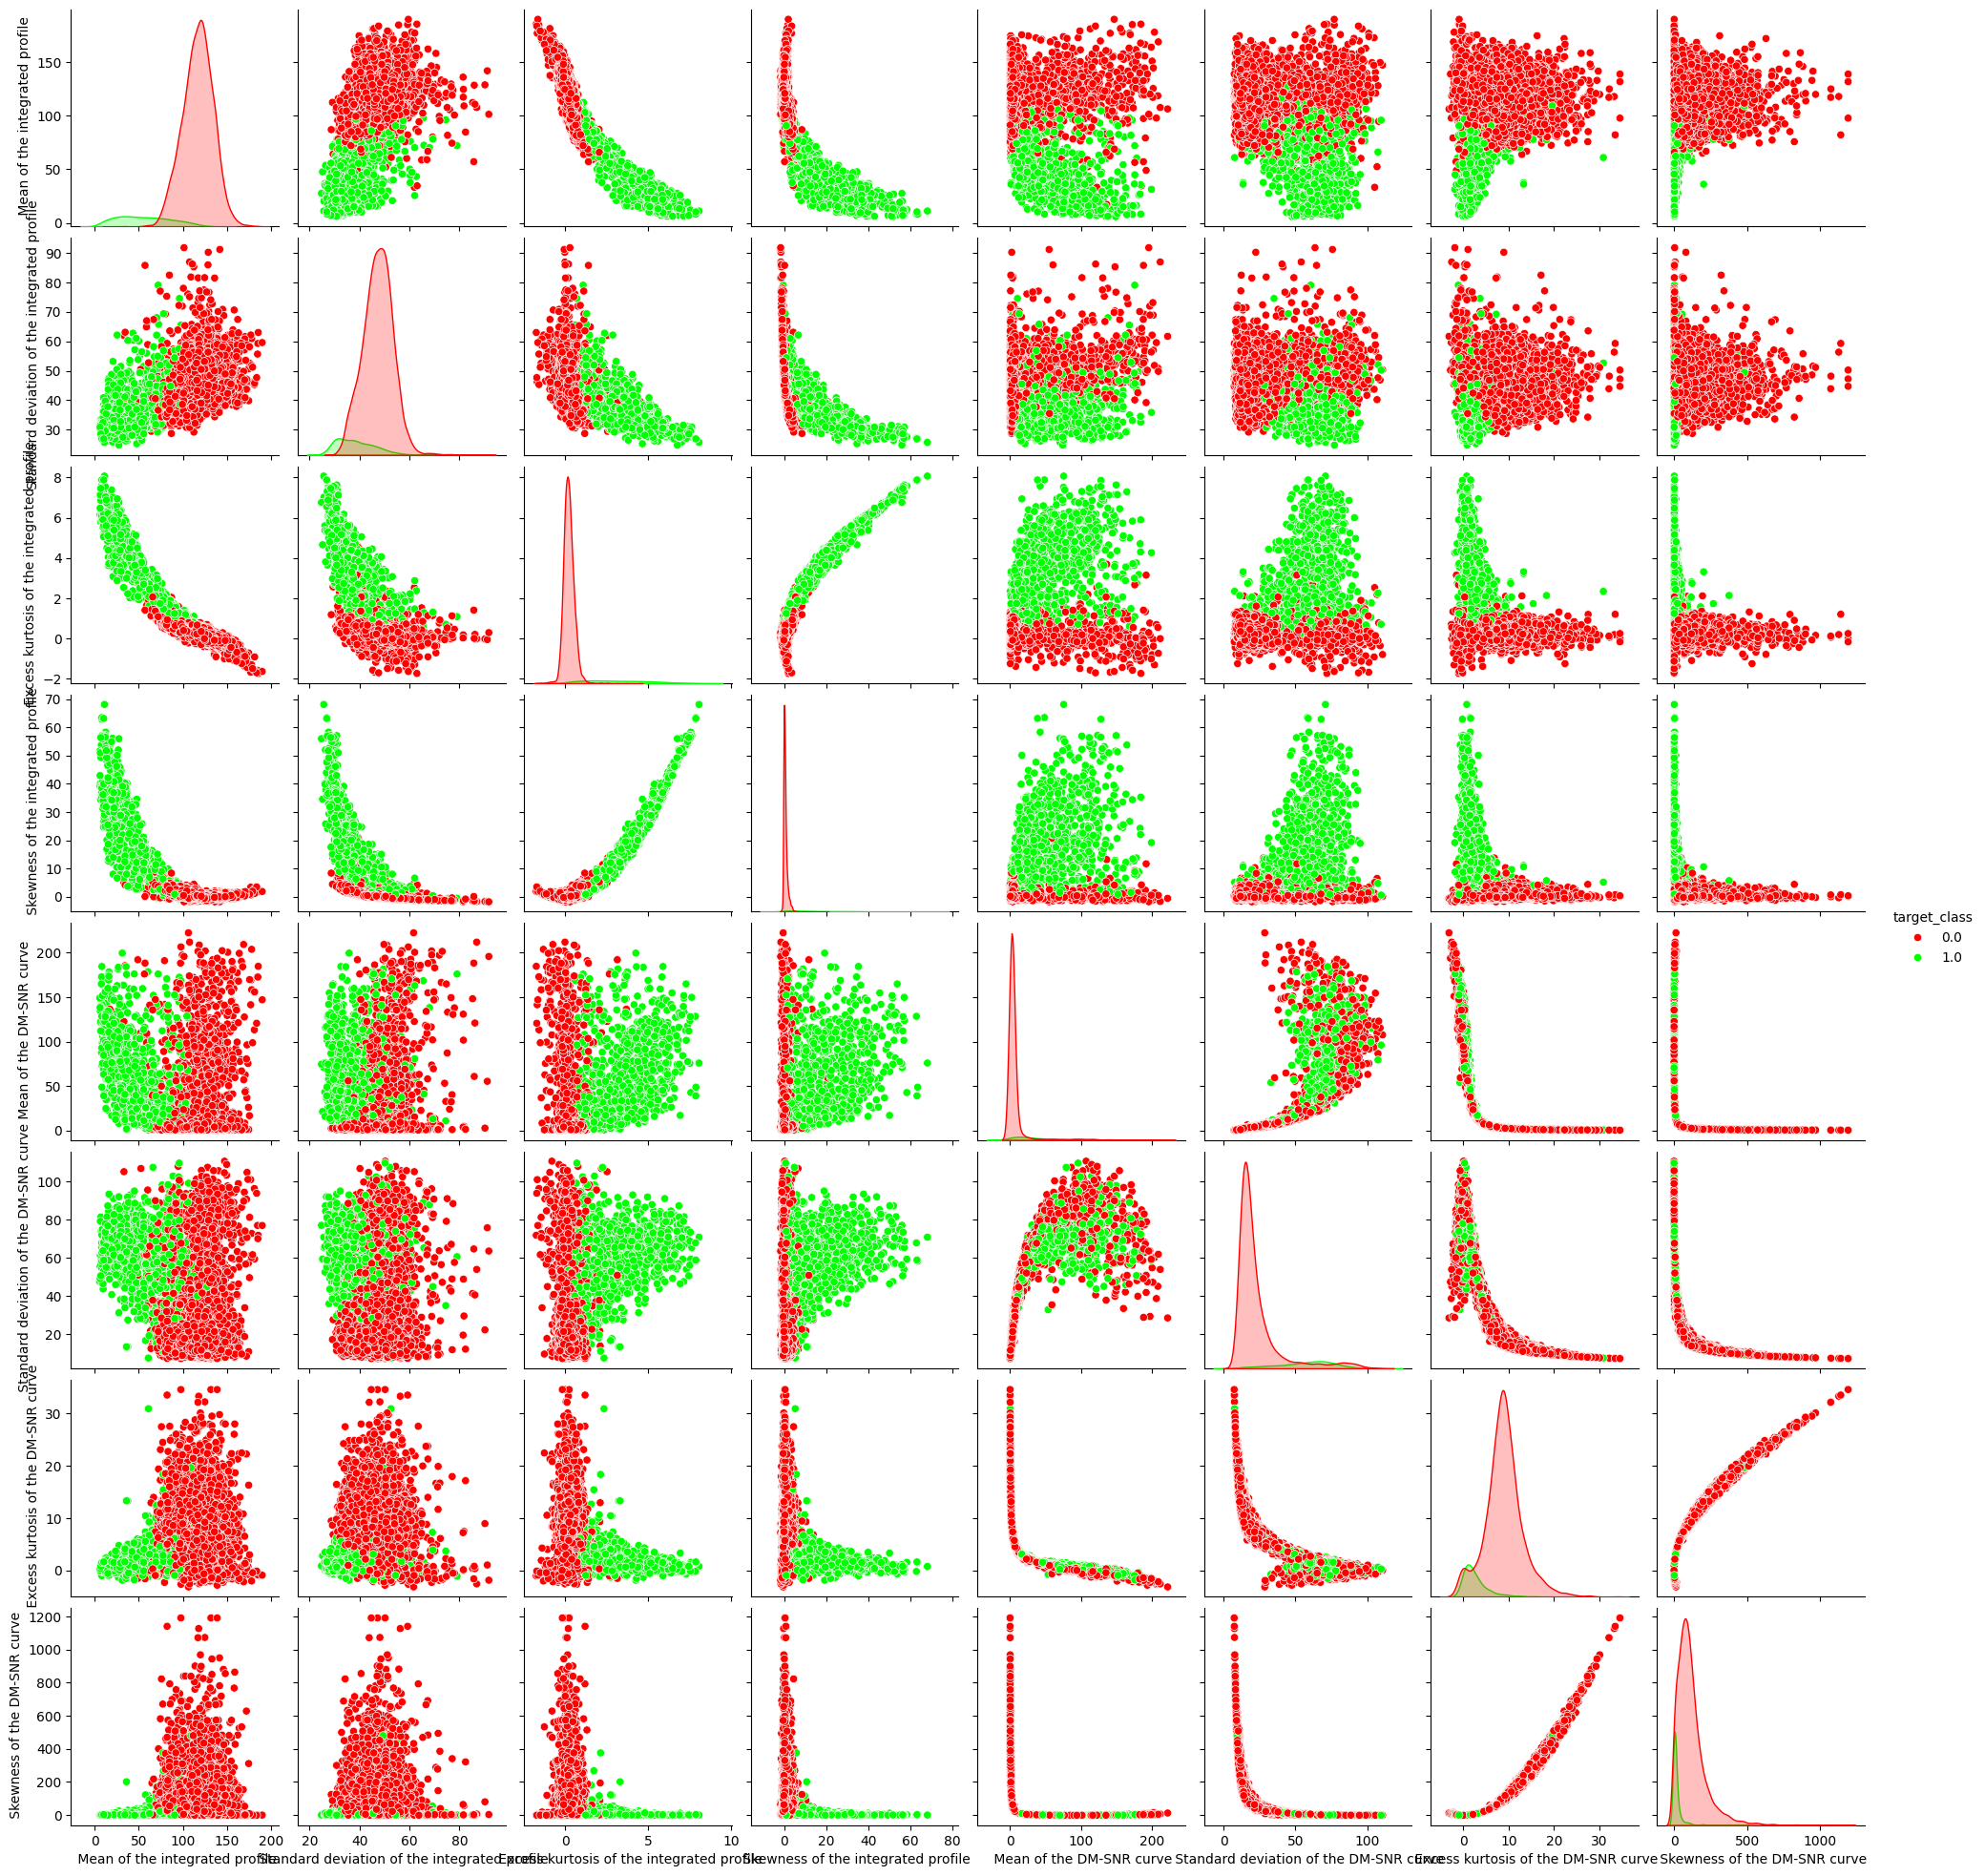

In [ ]:
sns.pairplot(pulsar_train_df, hue="target_class", palette=["red","lime"])
plt.show()

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(1, 0, ' Mean of the integrated profile'),
  Text(2, 0, ' Standard deviation of the integrated profile'),
  Text(3, 0, ' Excess kurtosis of the integrated profile'),
  Text(4, 0, ' Skewness of the integrated profile'),
  Text(5, 0, ' Mean of the DM-SNR curve'),
  Text(6, 0, ' Standard deviation of the DM-SNR curve'),
  Text(7, 0, ' Excess kurtosis of the DM-SNR curve'),
  Text(8, 0, ' Skewness of the DM-SNR curve'),
  Text(9, 0, 'target_class')])

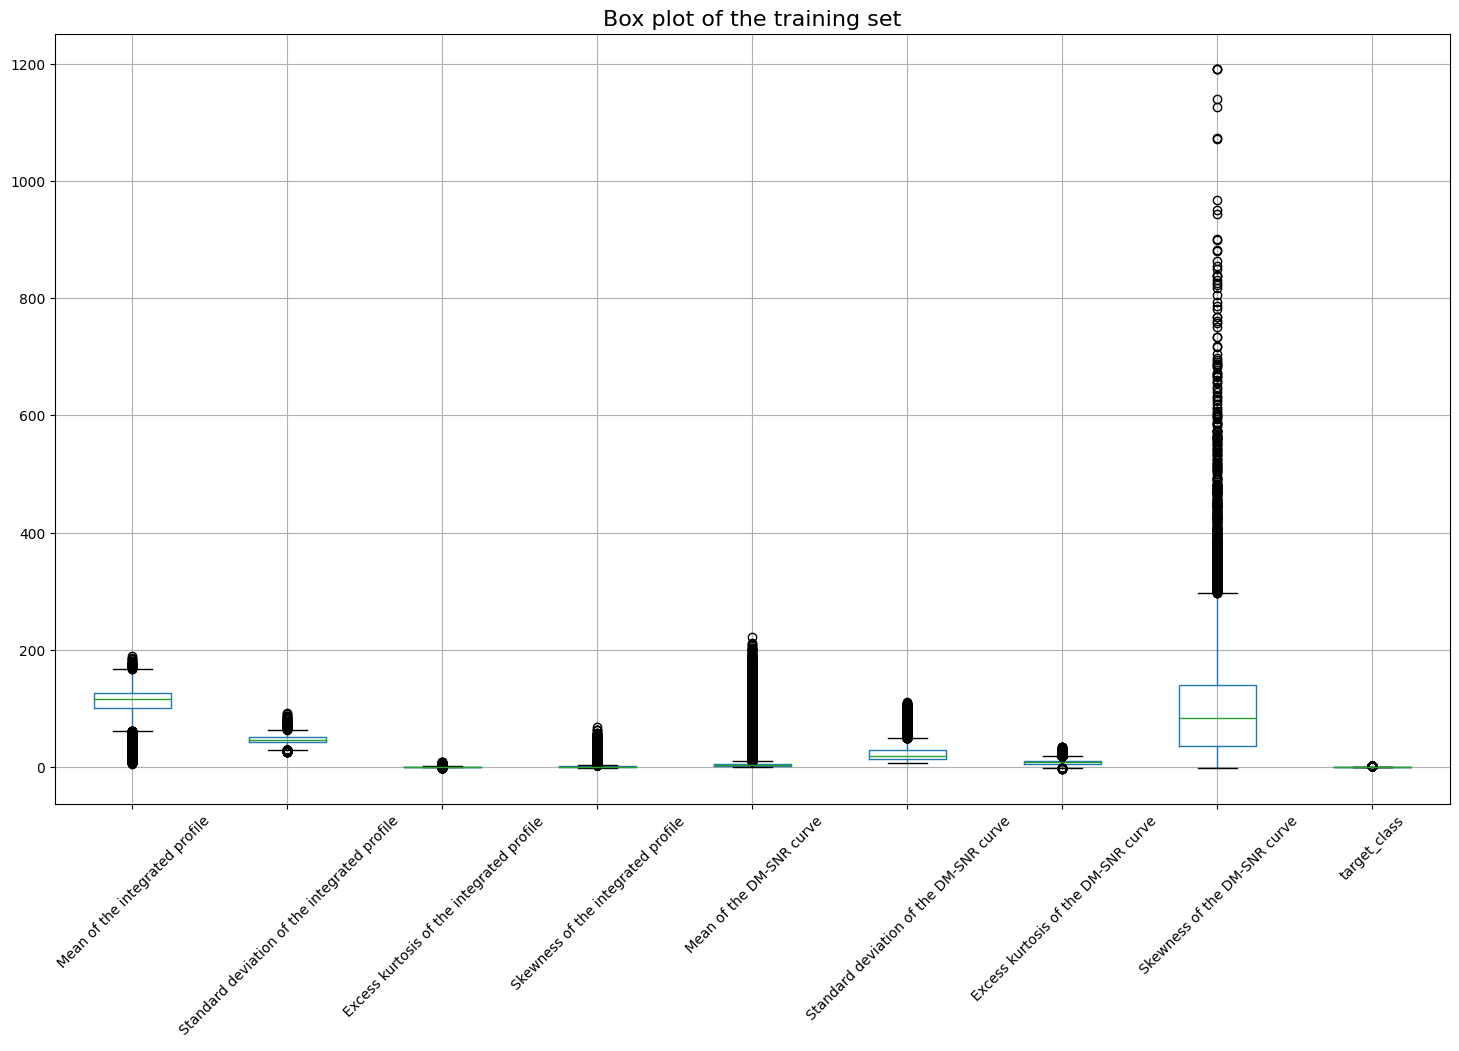

In [ ]:
# Box plotting to see if there are outliers
plt.figure(figsize=(18,10))
plt.title('Box plot of the training set',fontsize=16)
pulsar_train_df.boxplot()
plt.xticks(rotation=45)

In [ ]:
# filling missing values on our test set depending on the skewness of each feature
skewness = pulsar_test_df.skew()
print(skewness)

# We will impute everything using median
pulsar_test_df.columns = pulsar_test_df.columns.str.strip().str.replace("'", "")

# Performing imputation for each column based on the specified strategy
imp = SimpleImputer(strategy="median")

pulsar_test_df_imputed = pandas.DataFrame(imp.fit_transform(pulsar_test_df), columns=pulsar_test_df.columns.drop(['target_class']))

# Copying back the imputed data into the original dataframe
pulsar_test_df.update(pulsar_test_df_imputed)


pulsar_test_df = pulsar_test_df.rename(columns=dict(zip(pulsar_test_df.columns, feature_names_arr)))

pulsar_test_df.head(50)

#as you can see, there is no missing values
#let's do the same for the training set


 Mean of the integrated profile                 -1.348135
 Standard deviation of the integrated profile    0.219772
 Excess kurtosis of the integrated profile       3.552928
 Skewness of the integrated profile              5.045145
 Mean of the DM-SNR curve                        3.762464
 Standard deviation of the DM-SNR curve          1.883122
 Excess kurtosis of the DM-SNR curve             0.434087
 Skewness of the DM-SNR curve                    2.808774
target_class                                          NaN
dtype: float64


Mean of the integrated profile  \
0                        116.906250   
1                         75.585938   
2                        103.273438   
3                        101.078125   
4                        113.226562   
5                         85.476562   
6                        120.203125   
7                        131.921875   
8                        124.078125   
9                        115.789062   
10                       122.273438   
11                       106.812500   
12                       110.257812   
13                       146.359375   
14                       119.812500   
15                        91.679688   
16                       127.687500   
17                        87.398438   
18                        99.304688   
19                       105.882812   
20                        91.562500   
21                       128.046875   
22                       113.578125   
23                       137.265625   
24                        80.156250   
25                        97.632812   
26                        92.632812   
27                        86.101562   
28                       103.828125   
29                       132.671875   
30                       112.531250   
31                       115.226562   
32                       144.328125   
33                        87.375000   
34                       107.132812   
35                        19.359375   
36                       140.281250   
37                       109.625000   
38                       114.351562   
39                        76.218750   
40                       120.140625   
41                       126.523438   
42                       123.531250   
43                       114.343750   
44                       135.335938   
45                       117.484375   
46                       119.234375   
47                       119.890625   
48                       122.734375   
49                       139.617188   

     Standard deviation of the integrated profile  \
0                                       48.920605   
1                                       34.386254   
2                                       46.996628   
3                                       48.587487   
4                                       48.608804   
5                                       38.052793   
6                                       46.946339   
7                                       48.328564   
8                                       50.514789   
9                                       55.597135   
10                                      54.319183   
11                                      52.732187   
12                                      56.334554   
13                                      53.171117   
14                                      57.072288   
15                                      39.714004   
16                                      54.713994   
17                                      44.428724   
18                                      46.185522   
19                                      36.696309   
20                                      36.637103   
21                                      45.447060   
22                                      50.905336   
23                                      50.415227   
24                                      37.580629   
25                                      44.212709   
26                                      46.425658   
27                                      48.075598   
28                                      43.885702   
29                                      47.868164   
30                                      47.749499   
31                                      52.921701   
32                                      51.633188   
33                                      39.596204   
34                                      48.179575   
35                                      30.549073   
36                                      53.345562   
3

In [ ]:
# Displaying the skewness to see how to impute missing values in our training set

skewness = pulsar_train_df.skew()
print(skewness)

 Mean of the integrated profile                 -1.386845
 Standard deviation of the integrated profile    0.083716
 Excess kurtosis of the integrated profile       3.658438
 Skewness of the integrated profile              5.235255
 Mean of the DM-SNR curve                        3.650861
 Standard deviation of the DM-SNR curve          1.896039
 Excess kurtosis of the DM-SNR curve             0.443657
 Skewness of the DM-SNR curve                    2.708265
target_class                                     2.822913
dtype: float64


In [ ]:
# filling missing values on our training set depending on the skewness of each feature
imputation_strategies = {
    ' Mean of the integrated profile': 'median',
    ' Standard deviation of the integrated profile': 'mean',
    ' Excess kurtosis of the integrated profile': 'median',
    ' Skewness of the integrated profile': 'median',
    ' Mean of the DM-SNR curve': 'median',
    ' Standard deviation of the DM-SNR curve': 'median',
    ' Excess kurtosis of the DM-SNR curve': 'median',
    ' Skewness of the DM-SNR curve': 'median',
}

# Removing leading spaces from column names in imputation_strategies
imputation_strategies = {column.strip(): strategy for column, strategy in imputation_strategies.items()}

pulsar_train_df.columns = pulsar_train_df.columns.str.strip().str.replace("'", "")

# Performing imputation for each column based on the specified strategy
for column, strategy in imputation_strategies.items():
    imp = SimpleImputer(strategy=strategy)
    pulsar_train_df[column] = imp.fit_transform(pulsar_train_df[[column]])

pulsar_train_df.head(50)

Mean of the integrated profile  \
0                       121.156250   
1                        76.968750   
2                       130.585938   
3                       156.398438   
4                        84.804688   
5                       121.007812   
6                        79.343750   
7                       109.406250   
8                        95.007812   
9                       109.156250   
10                      130.085938   
11                       96.937500   
12                      146.695312   
13                      128.734375   
14                      102.367188   
15                      125.609375   
16                      150.093750   
17                      104.562500   
18                      115.781250   
19                      133.125000   
20                      125.148438   
21                       99.281250   
22                       83.937500   
23                      135.132812   
24                      111.710938   
25                      127.328125   
26                      101.914062   
27                      108.742188   
28                      128.484375   
29                      102.234375   
30                       98.570312   
31                       36.710938   
32                      108.757812   
33                      117.679688   
34                       43.500000   
35                      122.093750   
36                      121.554688   
37                      107.703125   
38                       84.546875   
39                      126.562500   
40                       66.851562   
41                      100.078125   
42                      135.265625   
43                      105.273438   
44                      142.968750   
45                      107.171875   
46                      126.273438   
47                      128.343750   
48                       89.445312   
49                      110.062500   

    Standard deviation of the integrated profile  \
0                                      48.372971   
1                                      36.175557   
2                                      53.229534   
3                                      48.865942   
4                                      36.117659   
5                                      47.176944   
6                                      42.402174   
7                                      55.912521   
8                                      40.219805   
9                                      47.002234   
10                                     46.402624   
11                                     40.537357   
12                                     47.806177   
13                                     48.695560   
14                                     49.842074   
15                                     53.514781   
16                                     56.700479   
17                                     46.658793   
18                                     53.305713   
19                                     59.957276   
20                                     46.000015   
21                                     71.956469   
22                                     45.712715   
23                                     47.871797   
24                                     46.570537   
25                                     45.339537   
26                                     52.239537   
27                                     47.589102   
28                                     50.991418   
29                                     44.507809   
30                                     45.069509   
31                                     38.260242   
32                                     47.470837   
33                                     47.457042   
34                                     28.491227   
35                                     50.783461   
36                                     58.891294   
37                                     44.726313   
38                                   

In [ ]:
# Removing leading spaces from column names of pulsar_test_df
pulsar_test_df.columns = pulsar_test_df.columns.str.strip().str.replace("'", "")


In [ ]:
# -------------------------------------- Scaling data -------------------------------------------
min_max_scaler = MinMaxScaler()

# Fitting and transforming the scaler on training data
X_train_scaled = min_max_scaler.fit_transform(pulsar_train_df.drop(columns=['target_class']))

# Transforming testing data using the scaler fitted on training data
X_test_scaled = min_max_scaler.transform(pulsar_test_df.drop(columns=['target_class']))


In [ ]:
param_grid = [
    {'C': [1, 100], 'kernel': ['linear']},
    {'C': [1, 100], 'kernel': ['rbf']},
    {'C': [1, 100], 'kernel': ['poly']},
    {'C': [1, 100], 'kernel': ['sigmoid']}
]

# Getting the labels from our training set
y_train = pulsar_train_df['target_class']

# Initializing our classifier
pulsar_clf = SVC()

# Scoring list containing our metrics used to evaluate our model results
scoring = {'accuracy': make_scorer(accuracy_score), 'f1_score': make_scorer(f1_score)}

# Doing a grid search to tune hyperparameters in order to find the best parameters for our model
grid_search = GridSearchCV(pulsar_clf, param_grid, cv=5, scoring=scoring, refit='accuracy', verbose=1)

# Fitting our model to our labels and features
grid_search.fit(X_train_scaled, y_train)

# Printing the best found parameters
print("Best parameters:", grid_search.best_params_)

# Printing the accuracy found by our model
print("Best accuracy:", grid_search.best_score_)

# Printing the F1-score of our model
print("F1 score corresponding to best accuracy:", grid_search.cv_results_['mean_test_f1_score'][grid_search.best_index_])

# Getting the list of predicitions that we got
y_pred = grid_search.predict(X_test_scaled)

# Printing our predictions
print(y_pred)

df_pred = pandas.DataFrame(y_pred, columns=['Predictions'])

# Saving the predictions DataFrame to a CSV file
df_pred.to_csv('y_pred_test.csv', index=False)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'C': 100, 'kernel': 'poly'}
Best accuracy: 0.9790069661156539
F1 score corresponding to best accuracy: 0.877618557646106
[0. 1. 0. ... 0. 0. 0.]


In [ ]:
# -------------------------------------------------------------------- Other version in which we treat outliers to compare results -----------------------


In [ ]:
# Treating Outliers by capping them

# ------------------------------- Training set --------------------------------------
#creating dataframe without outliers after treating missing values
pulsar_train_out = pulsar_train_df.copy()

def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

# Iterating over our dataframe until the last column before our target class
for column in pulsar_train_out.loc[:,:'Skewness of the DM-SNR curve'].columns: #I didn't took the target class here
    if pulsar_train_out[column].dtype != 'object':
        lr,ur=remove_outlier(pulsar_train_out[column])
        pulsar_train_out[column]=np.where(pulsar_train_out[column]>ur,ur,pulsar_train_out[column])
        pulsar_train_out[column]=np.where(pulsar_train_out[column]<lr,lr,pulsar_train_out[column])


In [ ]:
# Removing leading spaces from column names of pulsar_test_df
pulsar_test_df.columns = pulsar_test_df.columns.str.strip().str.replace("'", "")

In [ ]:
# ------------------------------- Test set --------------------------------------

#creating dataframe without outliers after treating missing values
pulsar_test_out = pulsar_test_df.copy()

# Iterating over our dataframe until the last column before our target class
for column in pulsar_test_out.loc[:,:'Skewness of the DM-SNR curve'].columns: #I didn't take the target class here
    if pulsar_test_out[column].dtype != 'object':
        lr,ur=remove_outlier(pulsar_test_out[column])
        pulsar_test_out[column]=np.where(pulsar_test_out[column]>ur,ur,pulsar_test_out[column])
        pulsar_test_out[column]=np.where(pulsar_test_out[column]<lr,lr,pulsar_test_out[column])


In [ ]:
# Box plotting to our training set after capping our data
plt.figure(figsize=(18,10))
plt.title('Box plot of the training set',fontsize=16)
pulsar_train_out.boxplot()
plt.xticks(rotation=45)

In [ ]:
# -------------------------------------- Scaling data -------------------------------------------
min_max_scaler = MinMaxScaler()

# Fitting and transforming the scaler on training data
X_train_scaled = min_max_scaler.fit_transform(pulsar_train_out.drop(columns=['target_class']))

# Transforming testing data using the scaler fitted on training data
X_test_scaled = min_max_scaler.transform(pulsar_test_out.drop(columns=['target_class']))


In [ ]:
param_grid = [
    {'C': [1, 100], 'kernel': ['linear']},
    {'C': [1, 100], 'kernel': ['rbf']},
    {'C': [1, 100], 'kernel': ['poly']},
    {'C': [1, 100], 'kernel': ['sigmoid']}
]

# Getting the labels from our training set
y_train = pulsar_train_out['target_class']

# Initializing our classifier
pulsar_clf = SVC()

# Scoring list containing our metrics used to evaluate our model results
scoring = {'accuracy': make_scorer(accuracy_score), 'f1_score': make_scorer(f1_score)}

# Doing a grid search to tune hyperparameters in order to find the best parameters for our model
grid_search = GridSearchCV(pulsar_clf, param_grid, cv=10, scoring=scoring, refit='accuracy', verbose=1)

# Fitting our model to our labels and features
grid_search.fit(X_train_scaled, y_train)

# Printing the best found parameters
print("Best parameters:", grid_search.best_params_)

# Printing the accuracy found by our model
print("Best accuracy:", grid_search.best_score_)

# Printing the F1-score of our model
print("F1 score corresponding to best accuracy:", grid_search.cv_results_['mean_test_f1_score'][grid_search.best_index_])

# Getting the list of predicitions that we got
y_pred = grid_search.predict(X_test_scaled)

# Printing our predictions
print(y_pred)


# South Africa Heart Dataset

Characteristics The ten features are defined as follows:

sbp: systolic blood pressure\
tobacco: cumulative tobacco (kg)\
ldl: low density lipoprotein cholesterol\
adiposity:\
famhist: family history of heart disease (Present=1, Absent=0)\
typea: type-A behavior\
obesity\
alcohol: current alcohol consumption\
age: age at onset\
chd: coronary heart disease (yes=1 or no=0) (Target)

In [ ]:
df = pandas.read_csv("SAheart.csv", sep=",", decimal=".")
df.head()

df.shape

print(df.describe())

df['chd'].value_counts()

              sbp     tobacco         ldl   adiposity       typea     obesity  \
count  462.000000  462.000000  462.000000  462.000000  462.000000  462.000000   
mean   138.326840    3.635649    4.740325   25.406732   53.103896   26.044113   
std     20.496317    4.593024    2.070909    7.780699    9.817534    4.213680   
min    101.000000    0.000000    0.980000    6.740000   13.000000   14.700000   
25%    124.000000    0.052500    3.282500   19.775000   47.000000   22.985000   
50%    134.000000    2.000000    4.340000   26.115000   53.000000   25.805000   
75%    148.000000    5.500000    5.790000   31.227500   60.000000   28.497500   
max    218.000000   31.200000   15.330000   42.490000   78.000000   46.580000   

          alcohol         age  
count  462.000000  462.000000  
mean    17.044394   42.816017  
std     24.481059   14.608956  
min      0.000000   15.000000  
25%      0.510000   31.000000  
50%      7.510000   45.000000  
75%     23.892500   55.000000  
max    147.190

No    302
Si    160
Name: chd, dtype: int64

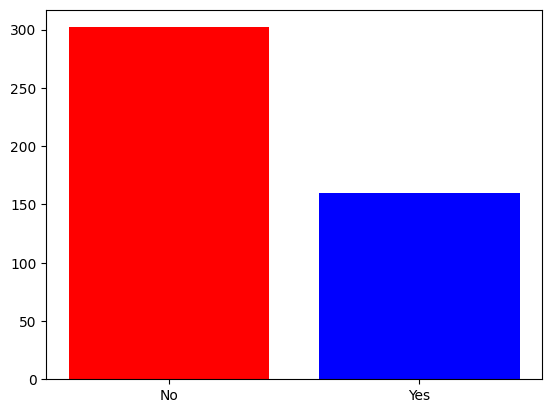

In [ ]:
# the plot shows us the imbalancy of the targets
chd_no = df['chd'].value_counts().iloc[0]
chd_yes = df['chd'].value_counts().iloc[1]


plt.bar([0,1], [chd_no, chd_yes], color = ["red", "blue"])
plt.xticks([0,1], ["No","Yes"])
plt.show()

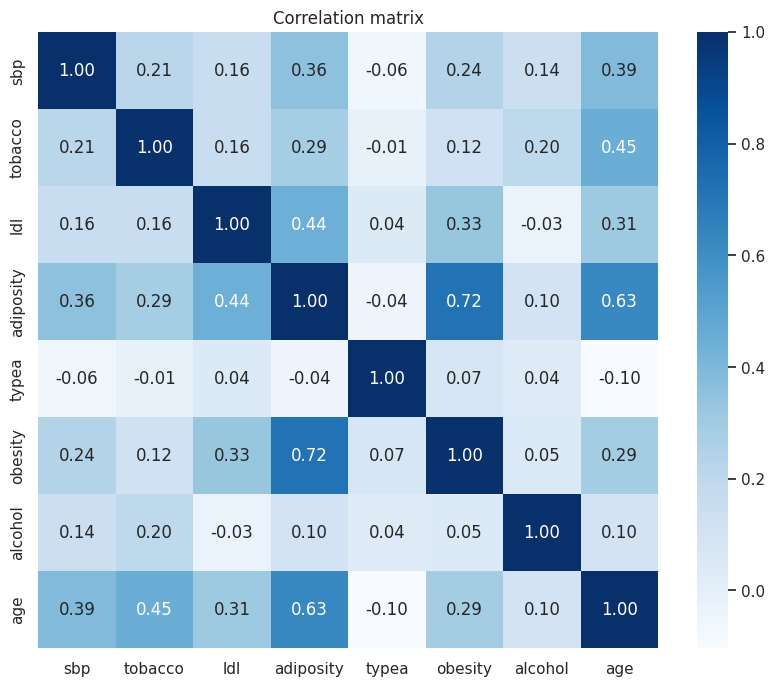

In [ ]:
numeric_columns = df.select_dtypes(include=['float64', 'int64'])


corr_matrix = numeric_columns.corr()

# Plot
plt.figure(figsize=(10, 8))
sns.set(style="white")
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")

plt.title('Correlation matrix')


plt.show()

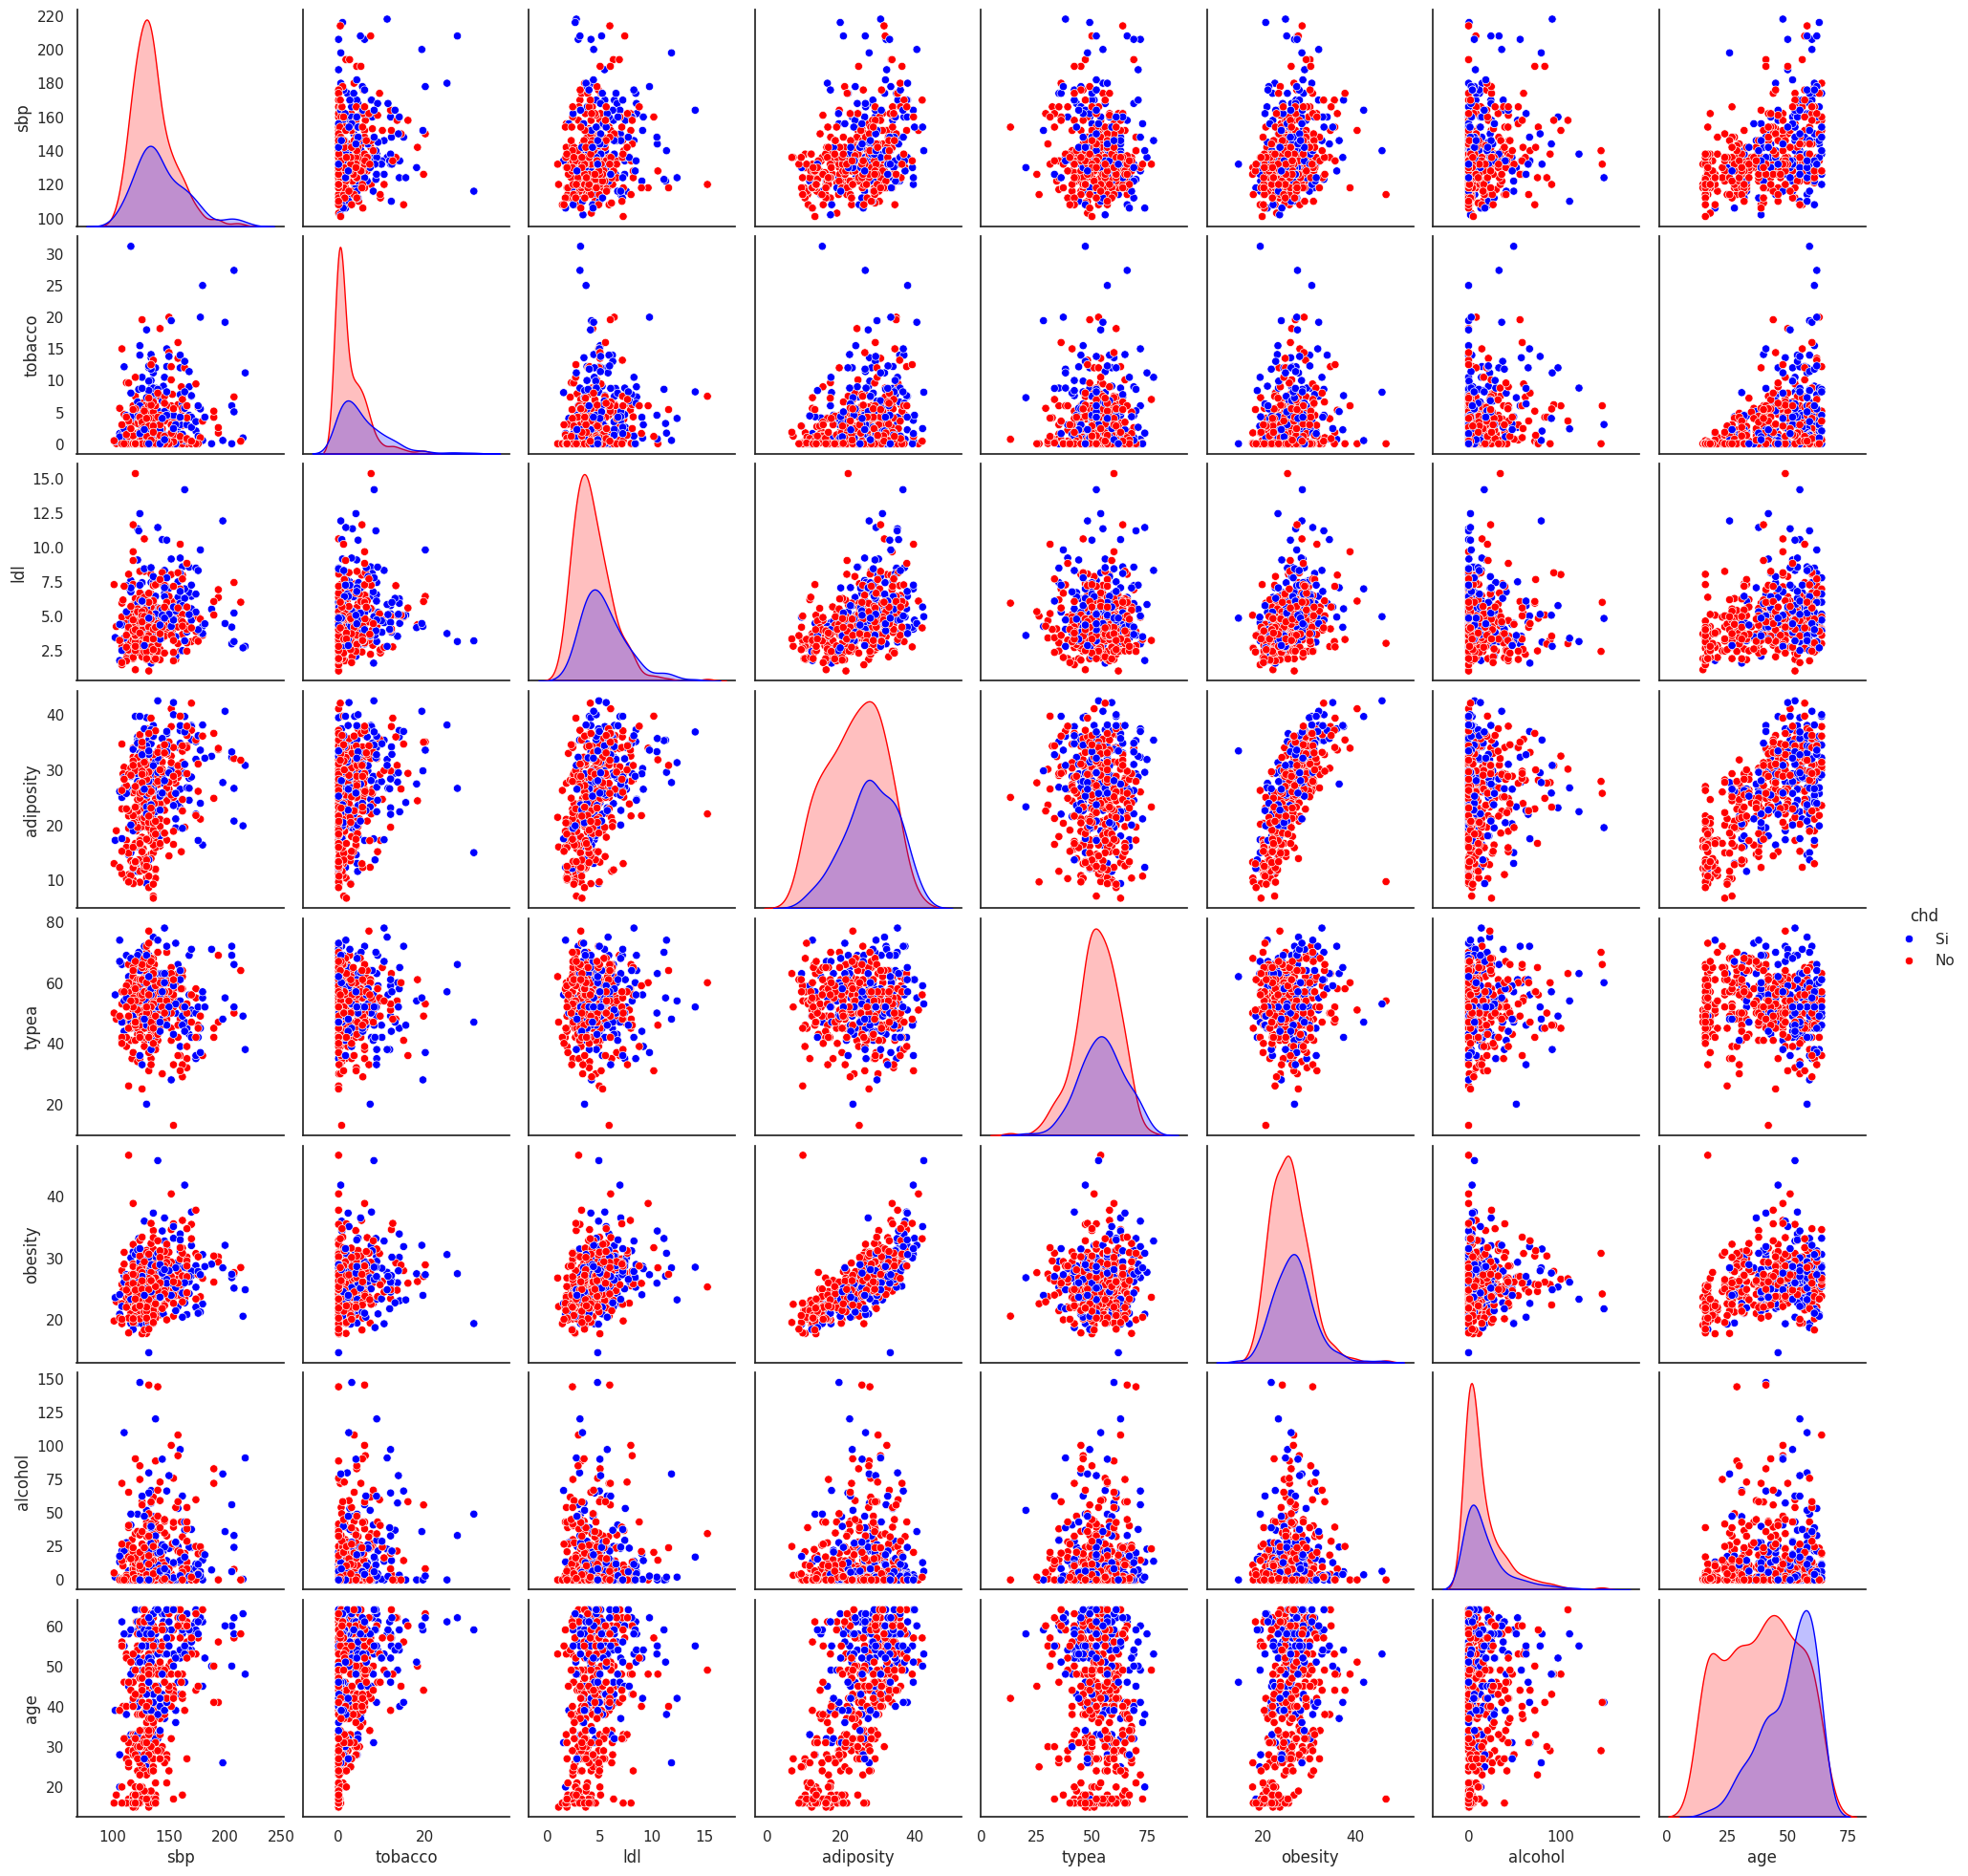

In [ ]:
sns.pairplot(df, hue='chd', palette={'No': 'red', 'Si': 'blue'})
# display of the plot
plt.show()

Doublons dans le jeu de données :
Empty DataFrame
Columns: [sbp, tobacco, ldl, adiposity, famhist, typea, obesity, alcohol, age, chd]
Index: []
shape of X
(462, 9)
shape of y
(462,)


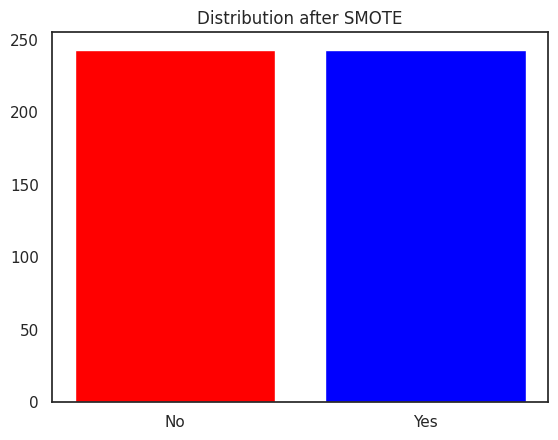

shape of X resampled
(486, 10)
shape of y resampled
(486,)


In [ ]:
# We create our classifier

clf = SVC()
duplicates = df[df.duplicated()]
print("Doublons dans le jeu de données :")
print(duplicates)
#shape of the df
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_encoded = pandas.get_dummies(X)
#shape of X

print('shape of X')
print(X.shape)

#shape of y
print('shape of y')
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


#Now because of imbalancy of the data, we use SMOTE to
smote = SMOTE(sampling_strategy='auto', random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


value_no = y_resampled.value_counts().iloc[0]
value_yes= y_resampled.value_counts().iloc[1]

plt.bar([0,1], [value_no, value_yes], color = ["red", "blue"])
plt.xticks([0,1], ["No","Yes"])
plt.title('Distribution after SMOTE')
plt.show()
#shape of X resampled

print('shape of X resampled')
print(X_resampled.shape)

#shape of y resampled
print('shape of y resampled')
print(y_resampled.shape)

Best Parameters: {'kernel': 'linear'}

Classification Report for kernel parameter :
              precision    recall  f1-score   support

          No       0.80      0.81      0.81        59
          Si       0.67      0.65      0.66        34

    accuracy                           0.75        93
   macro avg       0.73      0.73      0.73        93
weighted avg       0.75      0.75      0.75        93



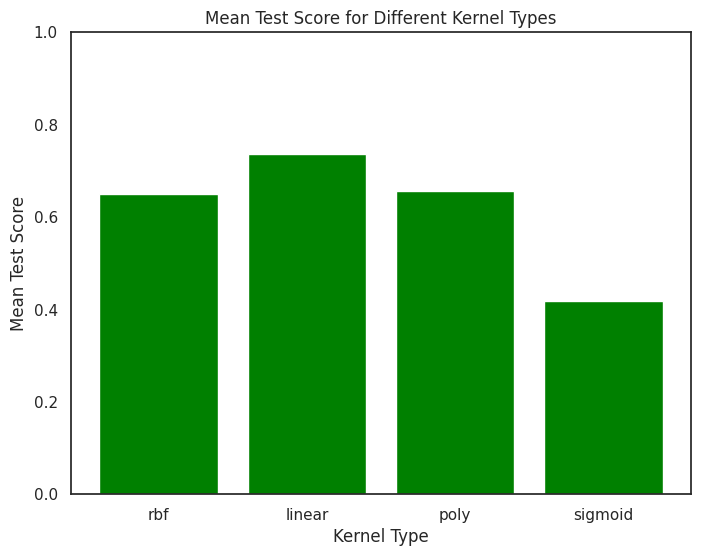

In [ ]:


param_grid_kernel = {'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}  # Kernel type
grid_search = GridSearchCV(clf, param_grid_kernel, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_resampled, y_resampled)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best estimator
best_svc = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_svc.predict(X_test)

# Print classification report
print("\nClassification Report for kernel parameter :")
print(classification_report(y_test, y_pred))


results = grid_search.cv_results_

# Obtenez les scores moyens pour chaque noyau
mean_scores = results['mean_test_score']

# Noyaux utilisés
kernels = ['rbf', 'linear', 'poly', 'sigmoid']

# Tracer les scores moyens
plt.figure(figsize=(8, 6))
plt.bar(kernels, mean_scores, color='green')
plt.xlabel('Kernel Type')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Score for Different Kernel Types')
plt.ylim([0, 1])
plt.show()

Best Parameters: {'degree': 21, 'kernel': 'poly'}

Classification Report for kernel parameter :
              precision    recall  f1-score   support

          No       0.67      0.78      0.72        59
          Si       0.46      0.32      0.38        34

    accuracy                           0.61        93
   macro avg       0.56      0.55      0.55        93
weighted avg       0.59      0.61      0.59        93



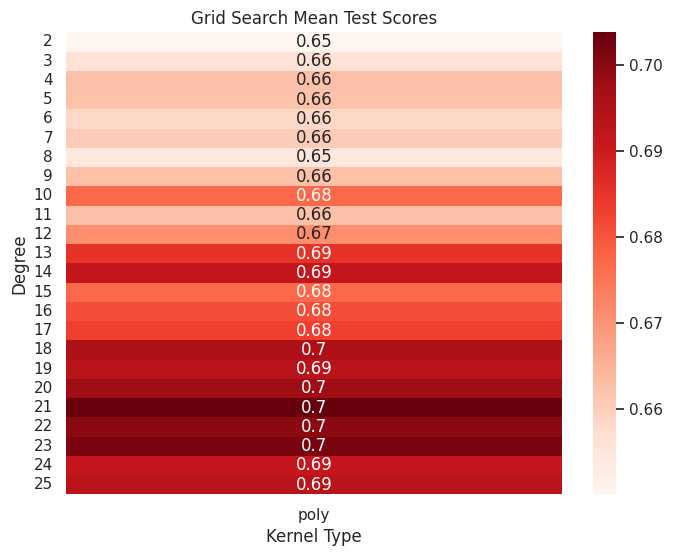

In [ ]:

param_grid_kernel = {'degree': np.arange(2,26), 'kernel': ['poly']}  # Kernel type
grid_search = GridSearchCV(clf, param_grid_kernel, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_resampled, y_resampled)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best estimator
best_svc = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_svc.predict(X_test)

# Print classification report
print("\nClassification Report for kernel parameter :")
print(classification_report(y_test, y_pred))

results = grid_search.cv_results_

# Get mean scores for each degree
mean_scores = results['mean_test_score']

# Reshape mean scores to make them two-dimensional
scores_matrix = mean_scores.reshape(len(param_grid_kernel['degree']), len(param_grid_kernel['kernel']))

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(scores_matrix, annot=True, cmap='Reds', xticklabels=param_grid_kernel['kernel'], yticklabels=param_grid_kernel['degree'])
plt.xlabel('Kernel Type')
plt.ylabel('Degree')
plt.title('Grid Search Mean Test Scores')
plt.show()

In [ ]:

param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best estimator
best_svc = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_svc.predict(X_test)

# Print classification report
print("\nClassification Report for C and gamma :")
print(classification_report(y_test, y_pred))
results = grid_search.cv_results_

# Récupérer les scores moyens pour chaque combinaison de paramètres
mean_scores = np.array(results['mean_test_score'])

# Reformater les scores pour les rendre bidimensionnels
scores_matrix = mean_scores.reshape(len(param_grid['C']), len(param_grid['gamma']))

# Tracer la grille de chaleur
plt.figure(figsize=(8, 6))
sns.heatmap(scores_matrix, annot=True, cmap='Reds', xticklabels=param_grid['gamma'], yticklabels=param_grid['C'])
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('Grid Search Mean Test Scores')
plt.show()

In [ ]:
clf = SVC(C=10, kernel='linear', gamma=0.001)
clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the model SVM:", accuracy)
